# A Practice on "MovieLens 100K Dataset": #3: Similarity-based Models

Now that we've established some simple baseline models and demonstrated that the Damped User + Movie Baseline model is the best of the few we tested, let's move on to some actual collaborative filtering models. Here, we'll explore user-based and item-based collaborative filtering. 

![Item-Based vs User-Based](https://github.com/benlindsay/movielens-analysis/blob/master/images/collaborativeFiltering-960x540.jpg?raw=1)

*Image found on [www.selemmarafi.com](http://www.salemmarafi.com/wp-content/uploads/2014/04/collaborativeFiltering-960x540.jpg)*

The idea of these methods is simply to predict unseen ratings by looking at how similar users rated a particular item, or by looking at how similar items were rated by a particular user. Both methods fall under the category of K-Nearest Neighbor (KNN) models, since ratings from the K most similar users or items are combined for the prediction.

Below, I've implemented a class called `KNNRecommender` that can accept a `mode` parameter of either `'user'` or `'item'`. Let's see how it compares to our best baseline!



# 0. Mount and load raw data

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [2]:
cd /gdrive/MyDrive/Lectures/2023/RecSys

/gdrive/MyDrive/Lectures/2023/RecSys


# 1. Import necessary modules and classes

In [3]:
# <!-- collapse=True -->
# Import necessary modules
%matplotlib inline
from datetime import datetime
from functools import reduce
from os.path import exists
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import KFold
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

# Import User + Movie baseline model
from cf_utils import DampedUserMovieBaselineModel

# Use custom matplotlib stylesheet
plt.style.use('seaborn-darkgrid')

<ipython-input-3-230343be5065>:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


# 2. Load the Data

Let's load and examine the ratings data. If you're following along (i.e. actually running these notebooks) you'll need to make sure to run the first one to download the data before running this one.

In [4]:
# <!-- collapse=True -->
ratings_df = pd.read_csv('raw/ml-100k/u.data', sep='\t', header=None, 
                         names=['userId', 'movieId', 'rating', 'timestamp'])
ratings_df['timestamp'] = ratings_df['timestamp'].apply(datetime.fromtimestamp)
ratings_df = ratings_df.sort_values('timestamp')
print('First 5:')
display(ratings_df.head())
print()
print('Last 5:')
display(ratings_df.tail())

First 5:


,userId,movieId,rating,timestamp
214,259,255,4,1997-09-20 03:05:10
83965,259,286,4,1997-09-20 03:05:27
43027,259,298,4,1997-09-20 03:05:54
21396,259,185,4,1997-09-20 03:06:21
82655,259,173,4,1997-09-20 03:07:23



Last 5:


,userId,movieId,rating,timestamp
46773,729,689,4,1998-04-22 23:10:38
73008,729,313,3,1998-04-22 23:10:38
46574,729,328,3,1998-04-22 23:10:38
64312,729,748,4,1998-04-22 23:10:38
79208,729,272,4,1998-04-22 23:10:38


# 3. Write our KNNRecommender class

In [5]:
# <!-- collapse=True -->
class KNNRecommender():
    """User-based or Item-based collaborative filtering model that operates on
    dataframes with at least a user-like, item-like, and a rating-like column
    
    Parameters
    ----------
    mode : str, ['item | 'user'], default='item'
        Tells model whether to use item-based or user-based collaborative filtering
    k : int, default=20
        Number of most similar items or users to average for prediction
    basline_algo : object, optional
        Algorithm used to predict baseline scores for each rating. If not provided,
        the mean of all training ratings is used as the baseline. If provided,
        the object must have a fit(X) method and a predict(X) method
    similarity_func : function, default=cosine_similarity
        Function must take a numpy array M of shape (m,n) and return a numpy array
        of shape (m,m) where each element i,j represents the similarity between row
        i and row j of M.
    loop_predict : boolean, default=True
        If True, the model will loop over all user-item pairs in test set and compute
        prediction individually. If False, the model will compute all ratings
        simultaneously. With sparse matrices, looping is typically faster.
        
    Attributes
    ----------
    train_mean : float
        Mean of the training data ratings. Used if baseline_algo is None.
    rating_matrix : 2d numpy array, shape=(n_users, n_items)
        Rating matrix minus baselines
    user_map : pandas Series, shape=(n_users,)
        Mapping from the original user id to an integer in the range [0,n_users)
    item_map : pandas Series, shape=(n_items,)
        Mapping from the original item id to an integer in the range [0,n_items)
    knn_indices : 2d numpy array, shape=([n_users|n_items], k)
        Element i,j represents the index of the jth closet [user|item] to i
    knn_similarities : 2d numpy array, shape=([n_users|n_items], k)
        Element i,j represents the similarity between the jth closest [user|item] to i
    """
    def __init__(self, mode='item', k=20, baseline_algo=None,
                 similarity_func=cosine_similarity, loop_predict=True):
        if not mode in ['user', 'item']:
            raise ValueError("'mode' must be either 'user' or 'item', not '{}'!".format(mode))

        self.mode = mode
        self.k = k
        self.baseline_algo = baseline_algo
        self.similarity_func = similarity_func
        self.loop_predict = loop_predict
        
        self.train_mean = None
        self.rating_matrix = None
        self.user_map = None
        self.item_map = None
        self.knn_indices = None
        self.knn_similarities = None
        
    def _get_rating_matrix(self, X):
        """Private function to generate a ratings matrx and mappings for
        the user and item ids to the row and column indices
        
        Parameters
        ----------
        X : pandas.DataFrame, shape=(n_ratings,>=3)
            First 3 columns must be in order of user, item, rating.
        
        Returns
        -------
        rating_matrix : 2d numpy array, shape=(n_users, n_items)
        user_map : pandas Series, shape=(n_users,)
            Mapping from the original user id to an integer in the range [0,n_users)
        item_map : pandas Series, shape=(n_items,)
            Mapping from the original item id to an integer in the range [0,n_items)
        """
        user_col, item_col, rating_col = X.columns[:3]
        rating = X[rating_col]
        user_map = pd.Series(
            index=np.unique(X[user_col]),
            data=np.arange(X[user_col].nunique()),
            name='user_map',
        )
        item_map = pd.Series(
            index=np.unique(X[item_col]),
            data=np.arange(X[item_col].nunique()),
            name='columns_map',
        )
        user_inds = X[user_col].map(user_map)
        item_inds = X[item_col].map(item_map)
        rating_matrix = (
            pd.pivot_table(
                data=X,
                values=rating_col,
                index=user_inds,
                columns=item_inds,
            )
            .fillna(0)
            .values
        )
        return rating_matrix, user_map, item_map

    def _get_knn_indices_and_similarities(self, rating_matrix):
        """Private function to find indices and similarities of k nearest
        neighbors for each user or item
        
        Parameters
        ----------
        rating_matrix : 2d numpy array, shape=(n_users, n_items)
            Matrix of ratings minus baselines
        
        Returns
        -------
        knn_indices : 2d numpy array, shape=([n_users|n_items], k)
            Element i,j represents the index of the jth closet [user|item] to i
        knn_similarities : 2d numpy array, shape=([n_users|n_items], k)
            Element i,j represents the similarity between the jth closest [user|item] to i
        """
        if self.mode == 'item':
            n_users_or_items = rating_matrix.shape[1]
        else:
            n_users_or_items = rating_matrix.shape[0]
        if self.k > n_users_or_items:
            new_k = n_users_or_items - 1
            print(
                "Warning: k = {} > # {}s = {}! Setting k to {}"
                .format(self.k, n_users_or_items, self.mode, new_k)
            )
            self.k = new_k
        if self.mode == 'item':
            similarity_matrix = self.similarity_func(rating_matrix.T)
        else:
            similarity_matrix = self.similarity_func(rating_matrix)
        np.fill_diagonal(similarity_matrix, -1)
        knn_indices = np.argsort(similarity_matrix, axis=1)[:, ::-1][:, :self.k]
        # https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/neighbors/base.py#L373
        sample_range = np.arange(len(knn_indices))[:, None]
        knn_similarities = similarity_matrix[sample_range, knn_indices]
        return knn_indices, knn_similarities
    
    def fit(self, X):
        """Fit model to training data X. Sets the knn_indices, knn_similarities, 
        rating_matrix, user_map, and item map variables.
        
        Parameters
        ----------
        X : pandas DataFrame, shape=(n_ratings, >=3)
            First 3 columns must correspond to user, item, and rating in that order
        
        Returns
        -------
        self
            This allows chaining like `KNNRecommender().fit(X_train).predict(X_test)`
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a DataFrame")
        X = X.copy()
        user_col, item_col, rating_col = X.columns[:3]
        if self.baseline_algo is None:
            self.train_mean = X[rating_col].mean()
            X['rating_baseline'] = self.train_mean
        else:
            self.baseline_algo.fit(X.iloc[:, :3])
            X['rating_baseline'] = self.baseline_algo.predict(X[[user_col, item_col]])
        X['rating_diff'] = X[rating_col] - X['rating_baseline']
        nodiff_rating_matrix, _, _ = self._get_rating_matrix(X[[user_col, item_col, rating_col]])
        self.knn_indices, self.knn_similarities = self._get_knn_indices_and_similarities(
            nodiff_rating_matrix
        )
        gc.collect()
        self.rating_matrix, self.user_map, self.item_map = self._get_rating_matrix(
            X[[user_col, item_col, 'rating_diff']]
        )
        return self

    def _predict_1_ui_pair(self, user, item):
        """Predict rating (minus baseline) for 1 user-item pair. Must add
        baseline to get the rating in the original rating scale.
        
        Parameters
        ----------
        user : int
            Must be in range [0, n_users)
        item : int
            Must be in range [0, n_items)
        
        Returns
        -------
        rating_pred : float
            Predicted ratings
        """
        if self.mode == 'item':
            inds_i = self.knn_indices[item, :]
            sims_i = self.knn_similarities[item, :]
            # https://stackoverflow.com/a/35696047/2680824
            numerator = np.sum(self.rating_matrix[user, inds_i] * sims_i)
            denominator = np.sum(np.abs(sims_i))
            with np.errstate(divide='ignore', invalid='ignore'):
                rating_pred = numerator / denominator
        else:
            inds_u = self.knn_indices[user, :]
            sims_u = self.knn_similarities[user, :]
            # https://stackoverflow.com/a/35696047/2680824
            numerator = np.sum(self.rating_matrix[inds_u, item] * sims_u)
            denominator = np.sum(np.abs(sims_u))
            with np.errstate(divide='ignore', invalid='ignore'):
                rating_pred = numerator / denominator
        return rating_pred

    def predict(self, X):
        """Predict ratings for each user-item pair in X
        
        Parameters
        ----------
        X : pandas DataFrame, shape=(n_ratings, >=2)
            First 2 columns of X must correspond to user and item.
        
        Returns
        -------
        pandas Series, shape=(n_ratings,)
            Ratings for each user-item pair in X. No restriction on the data type
            for the user and item ids, other than they must match the training indices.
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a DataFrame")
        X = X.copy()
        user_col, item_col = X.columns[:2]
        if self.baseline_algo is None:
            X['rating_baseline'] = self.train_mean
        else:
            X['rating_baseline'] = self.baseline_algo.predict(X)
        X['rating'] = 0
        known_user_and_item_mask = (
            X[user_col].isin(self.user_map.index) & X[item_col].isin(self.item_map.index)
        )
        X_known = X[known_user_and_item_mask]
        user_inds = X_known[user_col].map(self.user_map)
        item_inds = X_known[item_col].map(self.item_map)
        if self.loop_predict:
            rating_pred = np.array([
                self._predict_1_ui_pair(u_ind, i_ind)
                for u_ind, i_ind in zip(user_inds, item_inds)
            ])
        else:
            stacked_ratings = self.rating_matrix[
                self.knn_indices[:, :, None],
                np.arange(self.rating_matrix.shape[1])[None, None, :]
            ]
            numerator_matrix = np.sum(
                stacked_ratings * self.knn_similarities[:, :, None],
                axis=1
            )
            denominator_matrix = np.sum(
                (stacked_ratings != 0) * self.knn_similarities[:, :, None],
                axis=1
            )
            # https://stackoverflow.com/a/35696047/2680824
            with np.errstate(divide='ignore', invalid='ignore'):
                rating_pred_matrix = numerator_matrix / denominator_matrix
            rating_pred = rating_pred_matrix[user_inds, item_inds]
        rating_pred[np.isnan(rating_pred)] = 0
        X.loc[known_user_and_item_mask, 'rating'] = rating_pred
        return X['rating'] + X['rating_baseline']

# 4. Determine Optimal $k$ Values

In [6]:
# <!-- collapse=True -->
def cart_prod(df_1, df_2):
    df_1['_dummy_'], df_2['_dummy_'] = 1, 1
    return pd.merge(df_1, df_2, on='_dummy_').drop('_dummy_', axis=1)

In [7]:
# <!-- collapse=True -->
n_splits = 5
results_df = None

k_list = [1, 2, 5, 10, 20, 50, 100, 200]
mode_list = ['user', 'item']
i_fold_list = np.arange(n_splits)
df_1 = pd.DataFrame({'k': k_list})
df_2 = pd.DataFrame({'mode': mode_list})
df_3 = pd.DataFrame({'i_fold': i_fold_list})
results_df = reduce(cart_prod, [df_1, df_2, df_3])
results_df.head(10)

,k,mode,i_fold
0,1,user,0
1,1,user,1
2,1,user,2
3,1,user,3
4,1,user,4
5,1,item,0
6,1,item,1
7,1,item,2
8,1,item,3
9,1,item,4


In [8]:
results_df

,k,mode,i_fold
0,1,user,0
1,1,user,1
2,1,user,2
3,1,user,3
4,1,user,4
...,...,...,...
75,200,item,0
76,200,item,1
77,200,item,2
78,200,item,3


In [9]:
# <!-- collapse=True -->
kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)
# print(ratings_df.shape)
for (k, mode), group in results_df.groupby(['k', 'mode']):
    print("k={}, mode={}...".format(k, mode))
    # print("k={}, mode={}: i_fold= ".format(row['k'], row['mode']), end='')
    for (index, row), (train_inds, test_inds) in zip(group.iterrows(), kf.split(ratings_df)):
        print("i_fold={}, ".format(row['i_fold']), end='')
        train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
        baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
        t1 = datetime.now()
        rec = KNNRecommender(mode=row['mode'], k=row['k'], baseline_algo=baseline_algo)
        rec.fit(train_df)
        preds = rec.predict(test_df[['userId', 'movieId']])
        mae = mean_absolute_error(preds, test_df['rating'])
        results_df.loc[index, 'MAE'] = mae
        dt = (datetime.now() - t1).total_seconds()
        print("MAE={:5.3f}   dt={:.2f} seconds".format(mae, dt))
        results_df.loc[index, 'time'] = dt

k=1, mode=item...
i_fold=0, MAE=0.806   dt=1.29 seconds
i_fold=1, MAE=0.811   dt=1.09 seconds
i_fold=2, MAE=0.803   dt=1.07 seconds
i_fold=3, MAE=0.806   dt=1.10 seconds
i_fold=4, MAE=0.808   dt=0.94 seconds
k=1, mode=user...
i_fold=0, MAE=0.827   dt=1.01 seconds
i_fold=1, MAE=0.834   dt=0.89 seconds
i_fold=2, MAE=0.835   dt=1.32 seconds
i_fold=3, MAE=0.835   dt=1.31 seconds
i_fold=4, MAE=0.834   dt=1.12 seconds
k=2, mode=item...
i_fold=0, MAE=0.758   dt=0.95 seconds
i_fold=1, MAE=0.768   dt=0.90 seconds
i_fold=2, MAE=0.759   dt=0.96 seconds
i_fold=3, MAE=0.758   dt=0.95 seconds
i_fold=4, MAE=0.760   dt=0.94 seconds
k=2, mode=user...
i_fold=0, MAE=0.785   dt=0.87 seconds
i_fold=1, MAE=0.788   dt=0.84 seconds
i_fold=2, MAE=0.787   dt=1.03 seconds
i_fold=3, MAE=0.788   dt=0.90 seconds
i_fold=4, MAE=0.788   dt=0.97 seconds
k=5, mode=item...
i_fold=0, MAE=0.730   dt=1.30 seconds
i_fold=1, MAE=0.741   dt=1.48 seconds
i_fold=2, MAE=0.735   dt=1.34 seconds
i_fold=3, MAE=0.731   dt=1.19 second

In [10]:
# <!-- collapse=True -->
baseline_df = pd.DataFrame({'i_fold': i_fold_list})

for (index, row), (train_inds, test_inds) in zip(baseline_df.iterrows(), kf.split(ratings_df)):
    print("i_fold={}: MAE=".format(row['i_fold']), end='')
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
    baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
    baseline_algo.fit(train_df)
    preds = baseline_algo.predict(test_df[['userId', 'movieId']])
    mae = mean_absolute_error(preds, test_df['rating'])
    baseline_df.loc[index, 'MAE'] = mae
    print("{:5.3f}".format(mae))

i_fold=0: MAE=0.755
i_fold=1: MAE=0.765
i_fold=2: MAE=0.757
i_fold=3: MAE=0.752
i_fold=4: MAE=0.759


In [11]:
results_df

,k,mode,i_fold,MAE,time
0,1,user,0,0.827123,1.014620
1,1,user,1,0.833508,0.887024
2,1,user,2,0.835335,1.319145
3,1,user,3,0.834735,1.313890
4,1,user,4,0.833667,1.124314
...,...,...,...,...,...
75,200,item,0,0.741239,0.973179
76,200,item,1,0.751133,1.360726
77,200,item,2,0.743210,1.602107
78,200,item,3,0.738802,1.213219


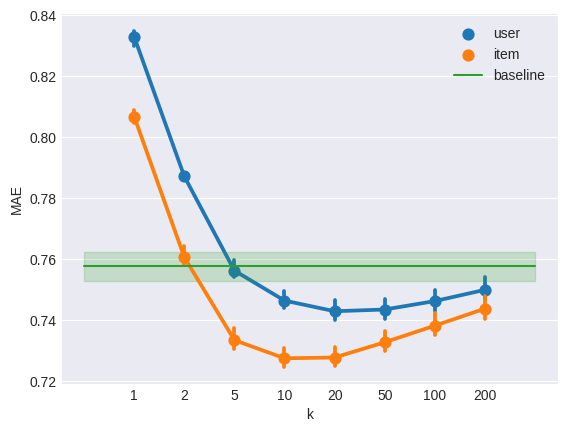

In [12]:
# <!-- collapse=True -->
base_avg = baseline_df['MAE'].mean()
base_std = baseline_df['MAE'].std()
sns.pointplot(data=results_df, x='k', hue='mode', y='MAE')
nk = results_df['k'].nunique()
plt.plot([-1, nk], [base_avg, base_avg], label='baseline', color='C2')
plt.fill_between([-1, nk], [base_avg - base_std]*2, [base_avg+base_std]*2, color='C2', alpha=0.2)
plt.legend()
plt.show()

Here we can see that Item-based collaborative filtering outperforms User-based collaborative filtering for all $k$. This occurs for the same reason that the Item average baseline performed better than the User average baseline: there are generally more ratings per item than there are ratings per user, since there are more users than movies. (This reverse is true for larger datasets like the [MovieLens 20M Dataset](https://grouplens.org/datasets/movielens/20m/) where there are more users than movies.)

We also see that the best Item-based CF model occurs around $k=10$ while the best User-based CF model occurs around $k=20$. We'll keep these in mind when comparing models later.

Next, we'll look at matrix factorization methods like Alternating Least Squares, so check out the next post/notebook!